In [295]:
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark import SparkContext
import numpy as np
import json
from tqdm import tqdm
import statsmodels.api as smf

## Popular climate change video analysis :)

### are they from already famous yt channels?

In [320]:
file_path = "data/refine_filtered_videos.jsonl"
videos_df = pd.read_json(file_path, lines=True)

In [321]:
videos_df.dropna(inplace=True, subset='view_count')
videos_df.sort_values(by='view_count', inplace=True, ascending=False)

In [298]:
videos_df.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
98845,Science & Technology,UC3O8-tKnz9VUn3sxZKyKN3w,2019-10-29 22:11:35.842626,India is amongst the top 5 countries in e-wast...,435.0,cFAylV8Wkwk,45,2302.0,"save environment,clean india,e waste,samsung v...",Samsung Care For Clean India Program,2019-07-28 00:00:00,144849603.0
22922,Entertainment,UCxo37Wc-azMveu1NXiCcAFA,2019-11-13 13:28:44.300683,While many of you may have asked who is Suraj ...,73761.0,QN7BFBqZ6qo,179,299040.0,"Suraj,Chakravarti,Viral,Funny,Hitachi AC,Funny...",Know the reason for extreme heat this summer! ...,2018-05-29 00:00:00,110302967.0
8642,Comedy,UCo8bcnLyZH8tBIH9V1mLgqQ,2019-11-13 19:47:27.635612,:)...just don't think about it too much\nBig t...,41982.0,CAb_bCtKuXg,240,1828260.0,"Life is Fun,music video,boyinaband,song,we are...",Life is Fun - Ft. Boyinaband (Official Music V...,2018-07-19 00:00:00,91103014.0
45975,Nonprofits & Activism,UCTZmwwn0Wd5YsAxw0NZzyJA,2019-10-31 17:47:36.335709,Water is the world’s most precious resource. N...,51125.0,677R2ezfAT8,60,112417.0,"WWF,WWF-Pakistan,World Water Week,Freshwater,S...",Elephant vs Giraffe Water Fight,2018-08-27 00:00:00,87753613.0
84427,Entertainment,UCAVns3lt0t7w8lmUZQFlvrA,2019-11-20 21:45:08.712305,GET THIS SONG ON ITUNES http://bit.ly/elsapoca...,23310.0,mIQr_TrFTUk,338,1316539.0,"after ever after,after ever after 2,jon cozart...",After Ever After 2 - DISNEY PARODY,2014-06-24 00:00:00,64374669.0


### The channels with the most influence with climate change related videos

In [299]:
views_climate_df = videos_df.groupby('channel_id').agg({'view_count': 'sum'}).reset_index().sort_values(by='view_count', ascending=False)
display(views_climate_df.head())

,channel_id,view_count
1819,UCAuUUnT6oDeKwE6v1NGQxug,218547507.0
654,UC3O8-tKnz9VUn3sxZKyKN3w,161728096.0
9645,UCxo37Wc-azMveu1NXiCcAFA,110902089.0
35,UC-CSyyi47VX1lD9zyeABW3w,97691501.0
8069,UCo8bcnLyZH8tBIH9V1mLgqQ,91103014.0


In [300]:
channels_path = 'data/df_channels_en.tsv'

ratios = videos_df['channel_id'].value_counts().reset_index()
ratios.columns = ['channel', 'count_climate_videos']

channels_df = pd.read_csv(channels_path, delimiter='\t')

channels_views_df = channels_df.merge(ratios, on ='channel', how ='left').fillna(0)
channels_views_df['proportion_climate_videos'] = channels_views_df['count_climate_videos']/channels_views_df['videos_cc']

views_climate_df.rename(columns={'channel_id': 'channel'}, inplace=True)
channels_views_df = channels_views_df.merge(views_climate_df, on ='channel', how ='left').fillna(0)

channels_views_df.sort_values(by='view_count', inplace=True, ascending=False)

In [301]:
display(channels_views_df.head())

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_climate_videos,proportion_climate_videos,view_count
137,People & Blogs,2006-12-06,UCAuUUnT6oDeKwE6v1NGQxug,TED,14800000,3105,211.0,2.0870,768.0,0.247343,218547507.0
1143,Science & Technology,2009-06-29,UC3O8-tKnz9VUn3sxZKyKN3w,SamsungIndia,4010000,166,2251.0,2.1530,2.0,0.012048,161728096.0
20927,Science & Technology,2011-05-28,UCxo37Wc-azMveu1NXiCcAFA,Hitachi Cooling & He...,249000,127,62453.0,3.8515,2.0,0.015748,110902089.0
1864,News & Politics,2013-01-07,UC-CSyyi47VX1lD9zyeABW3w,Dhruv Rathee,2220000,185,3883.0,2.2845,102.0,0.551351,97691501.0
185,Comedy,2014-08-30,UCo8bcnLyZH8tBIH9V1mLgqQ,TheOdd1sOut,12700000,113,288.0,2.0870,1.0,0.008850,91103014.0


### Regression to see if cc videos attract new viewers

In [302]:
#col = ['channel_id', 'display_id', 'view_count']
videos_df.rename(columns={'channel_id': 'channel'}, inplace=True)

#sample_vid_df = pd.read_json('data/sampled_dataset_01percent.jsonl', lines=True)
#sample_vid_df.rename(columns={'channel_id': 'channel'}, inplace=True)
#sample_vid_df = sample_vid_df.head(1000)

videos_subscribers_df = videos_df.merge(channels_df, on ='channel', how ='left').fillna(0)
columns_keep = ['channel', 'subscribers_cc', 'view_count']
videos_subscribers_df = videos_subscribers_df[columns_keep]
videos_subscribers_df.sort_values(by='subscribers_cc', inplace=True, ascending=False)

display(videos_subscribers_df.head())

,channel,subscribers_cc,view_count
751,UCq-Fj5jknLsUf-MWSy4_brA,112139463,1060271.0
1433,UC295-Dw_tDNtZXFeAPAW6Aw,60600000,534868.0
465,UC295-Dw_tDNtZXFeAPAW6Aw,60600000,1607483.0
1525,UCpEhnqL0y41EpW2TvWAHD7Q,56018869,493718.0
668,UCpEhnqL0y41EpW2TvWAHD7Q,56018869,1169378.0


                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     227.7
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           2.11e-51
Time:                        14:59:03   Log-Likelihood:            -1.7253e+06
No. Observations:              114862   AIC:                         3.451e+06
Df Residuals:                  114860   BIC:                         3.451e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.166e+04   2515.987     12.

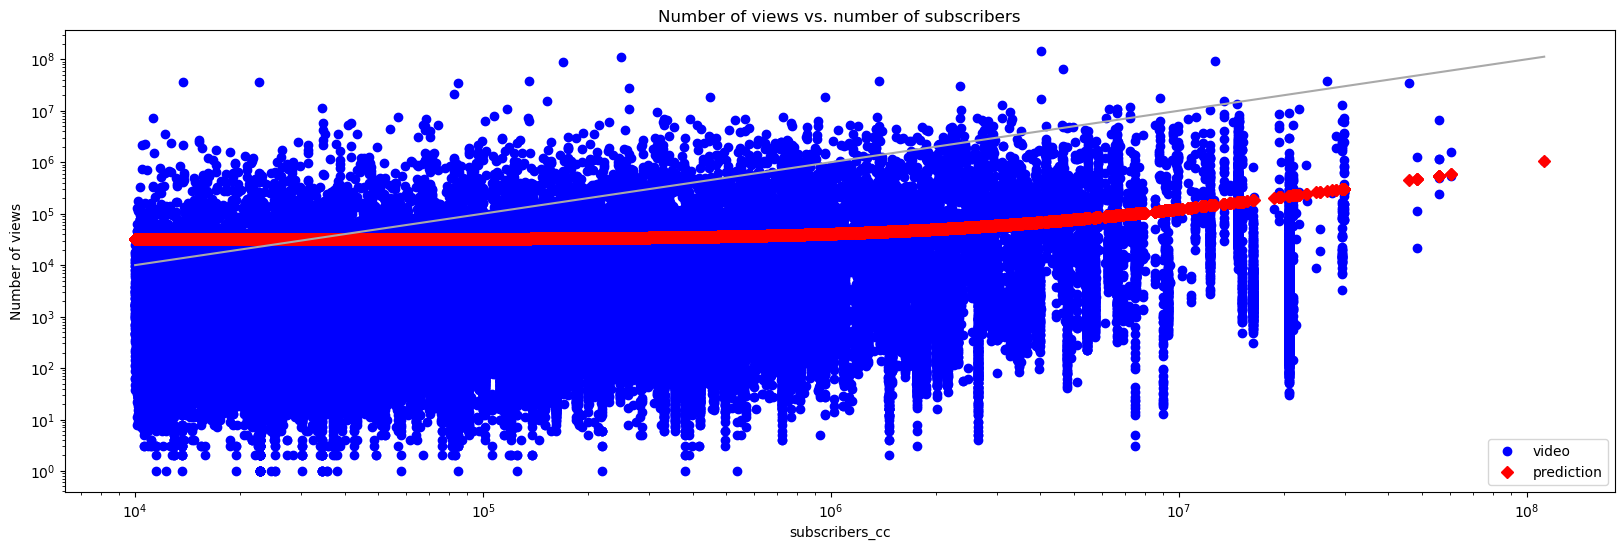

In [303]:
fig, ax = plt.subplots(figsize = (20, 6))

x = range(10**4, 112139463, 1000)

#plt.scatter(videos_subscribers_df.view_count, videos_subscribers_df.subscribers_cc, alpha=0.1)
model = smf.formula.ols(formula='view_count ~ subscribers_cc', data=videos_subscribers_df, missing='drop').fit()
smf.graphics.plot_fit(model, 1, ax=ax, vlines=False)
ax.set_xscale("log")
ax.set_yscale("log")
print(model.summary())

plt.plot(x, x, color='darkgray')

plt.title('Number of views vs. number of subscribers')
plt.legend(['video', 'prediction'], loc='lower right')
plt.ylabel('Number of subscribers')
plt.ylabel('Number of views')
plt.show()

instead of subscribers avg view_count cuz it will tell us more

In [304]:
timeseries_df = pd.read_csv('DATA/df_timeseries_en.tsv', delimiter='\t')
display(timeseries_df.head(2))

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03 00:00:00,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10 00:00:00,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17 00:00:00,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24 00:00:00,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31 00:00:00,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0


In [305]:
tt_views_df = timeseries_df[['channel', 'views', 'videos']] #j'espere c'est sort par datetime pour chaque channel
tt_views_df = tt_views_df.groupby('channel').last()
tt_views_df.rename(columns={'views': 'tt_views', 'videos': 'tt_videos'}, inplace=True)
display(tt_views_df.head())

,tt_views,tt_videos
channel,,
UC--24Q3_ZQeFmgJE-Um5QZQ,4.356804e+06,188
UC--2EbuIuBOGgGqPiJxi3rg,7.951972e+06,60
UC--3c8RqSfAqYBdDjIG3UNA,5.798712e+07,333
UC--3ozenTzry39-xMqAPQlw,1.455123e+07,43
UC--6E6EpybocdaNlPhvK_9A,9.166274e+06,31


In [306]:
tt_views_cc_df = videos_df[['channel', 'view_count']].groupby('channel').agg(['sum', 'count'])
tt_views_cc_df.columns = tt_views_cc_df.columns.to_flat_index()
tt_views_cc_df.rename(columns={('view_count', 'sum'): 'tt_cc_views', ('view_count', 'count'): 'tt_cc_videos'}, inplace=True)
display(tt_views_cc_df.head(2))

,tt_cc_views,tt_cc_videos
channel,,
UC--70ql_IxJmhmqXqrkJrWQ,7604.0,1
UC-0_aCN0_CSiJ6s7ryG2EtA,1094.0,1
UC-0cdtgZF01T3N8drruyikg,127818.0,1
UC-0glaRVSX-yzC-0kj4k-rA,1536.0,2
UC-0o65Lf1PjgLMn_SNM_-IA,8554.0,2


In [307]:
vid_views_df = tt_views_df.merge(tt_views_cc_df, how='inner', on='channel')
vid_views_df['avg_views_wo_cc'] = (vid_views_df['tt_views'] - vid_views_df['tt_cc_views'])/(vid_views_df['tt_videos'] - vid_views_df['tt_cc_videos'])
vid_views_df['avg_views_w_cc'] = vid_views_df['tt_cc_views']/vid_views_df['tt_cc_videos']
vid_views_df['avg_views'] = vid_views_df['tt_views']/vid_views_df['tt_videos']
display(vid_views_df.head(2))
# croyez le ou non des channels ont plus de videos cc que de videos totales
# et c'est pas pcq ils ont plus de videos tt que de videos cc que y'a plus de vues tt que de vues cc

,tt_views,tt_videos,tt_cc_views,tt_cc_videos,avg_views_wo_cc,avg_views_w_cc,avg_views
channel,,,,,,,
UC--70ql_IxJmhmqXqrkJrWQ,2.070418e+07,243,7604.0,1,85523.031877,7604.0,85202.377425
UC-0_aCN0_CSiJ6s7ryG2EtA,9.143875e+06,1051,1094.0,1,8707.410204,1094.0,8700.166236
UC-0cdtgZF01T3N8drruyikg,1.055336e+07,181,127818.0,1,57919.688889,127818.0,58305.867403
UC-0glaRVSX-yzC-0kj4k-rA,4.693658e+07,793,1536.0,2,59336.341904,768.0,59188.628558
UC-0o65Lf1PjgLMn_SNM_-IA,2.566806e+06,91,8554.0,2,28744.407705,4277.0,28206.662480


In [308]:
vid_views_df = vid_views_df[vid_views_df['tt_cc_videos']<vid_views_df['tt_videos']].dropna()
vid_views_df = vid_views_df[vid_views_df['avg_views_wo_cc']>0].dropna()

# debug weird values
jsp2 = vid_views_df[['avg_views_wo_cc']].idxmin()
display(vid_views_df.loc[jsp2[0]])

C:\Users\nasta\AppData\Local\Temp\ipykernel_18048\1173963796.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  display(vid_views_df.loc[jsp2[0]])


tt_views           127379.011905
tt_videos             961.000000
tt_cc_views           135.000000
tt_cc_videos            1.000000
avg_views_wo_cc       132.545846
avg_views_w_cc        135.000000
avg_views             132.548399
Name: UCd6V9TvLWmHmTTM29tUDGpg, dtype: float64

                            OLS Regression Results                            
Dep. Variable:        avg_views_wo_cc   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     2076.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:59:49   Log-Likelihood:            -1.4993e+05
No. Observations:                9795   AIC:                         2.999e+05
Df Residuals:                    9793   BIC:                         2.999e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.231e+05   1.09e+04     11.

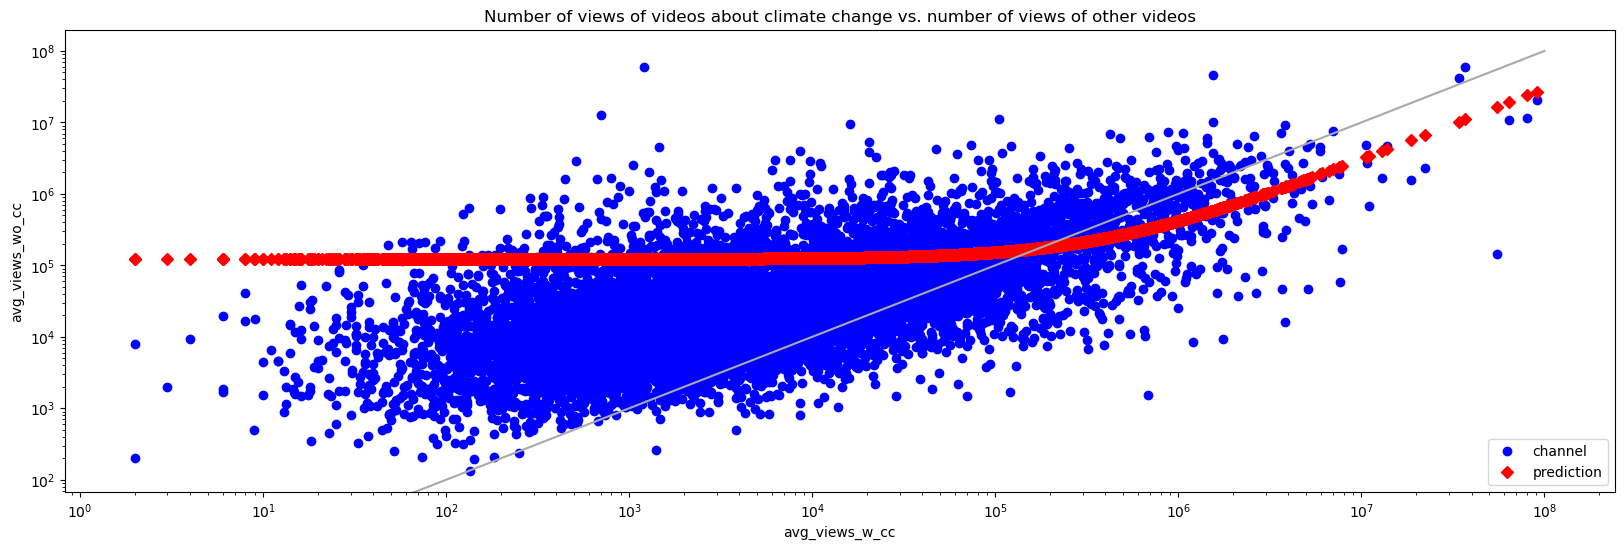

In [309]:
fig, ax = plt.subplots(figsize = (20, 6))

model2 = smf.formula.ols(formula='avg_views_wo_cc ~ avg_views_w_cc', data=vid_views_df, missing='drop').fit()
smf.graphics.plot_fit(model2, 1, ax=ax, vlines=False)
ax.set_xscale("log")
ax.set_yscale("log")
print(model2.summary())

x = range(0, 10**8, 1000)
plt.plot(x, x, color='darkgray')

plt.title('Number of views of videos about climate change vs. number of views of other videos')
plt.legend(['channel', 'prediction'], loc='lower right')
#plt.ylabel('Views of videos not about climate change')
#plt.ylabel('Views of videos about climate change')
plt.show()

In [310]:
ch_views_df = vid_views_df.sort_values(by='tt_cc_videos', ascending=False)
ch_views_df = ch_views_df.merge(channels_views_df[['channel', 'name_cc', 'subscribers_cc', 'proportion_climate_videos']], on ='channel', how ='inner').fillna(0)
ch_views_df = ch_views_df.set_index('name_cc')
channels20_df = ch_views_df.head(20)
display(ch_views_df.head())

,channel,tt_views,tt_videos,tt_cc_views,tt_cc_videos,avg_views_wo_cc,avg_views_w_cc,avg_views,subscribers_cc,proportion_climate_videos
name_cc,,,,,,,,,,
TEDx Talks,UCsT0YIqwnpJCM-mx7-gSA4Q,3.734520e+09,141827,48693392.0,3116,26571.984839,15626.890886,26331.516432,20700000,0.022001
paul8kangas,UCtYjvLEq6FCTWHUX_qtDJpw,6.981978e+06,11935,1137584.0,2365,610.699433,481.008034,585.000215,22900,0.197825
The Real Truth About...,UCp_ShZAUGtFLpYkgcTrayRQ,1.486650e+07,1598,12797545.0,1509,23246.741573,8480.811796,9303.194618,120000,0.944897
United Nations,UC5O114-PQNYkurlTg6hekZw,8.040280e+07,10321,17033935.0,1199,6946.816660,14206.784821,7790.213794,446000,0.119732
Suspicious0bservers,UCTiL1q9YbrVam5nP2xzFTWQ,1.286729e+08,3595,45167206.0,1109,33590.371164,40727.868350,35792.174886,428000,0.309172
...,...,...,...,...,...,...,...,...,...,...
Dawn Somewhere,UCSNd59iRYuFSqo-vb0qjJuQ,4.726197e+07,763,4725.0,1,62017.378328,4725.000000,61942.290021,181000,0.001309
All New Bricks,UCSMV8NLkBvRpCCVI4OInB0Q,3.315096e+08,373,267890.0,1,890434.830645,267890.000000,888765.809651,632000,0.002681
wtiiwarcraft,UCSLkuZD3BR_4vujh_NKwm1w,4.291564e+07,2491,16508.0,1,17228.568789,16508.000000,17228.279521,70400,0.000404


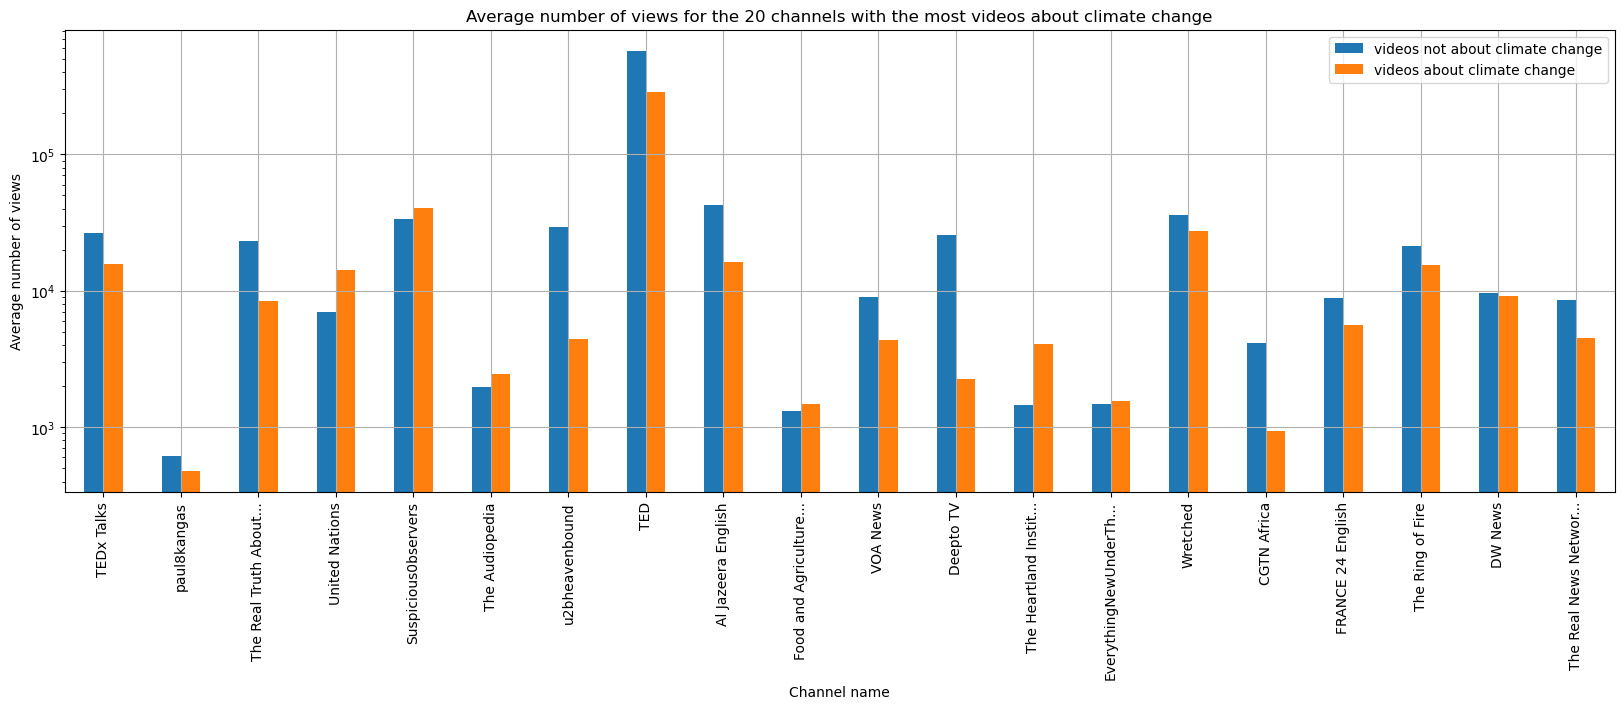

In [311]:
fig, ax = plt.subplots(figsize = (20, 6))
channels20_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='bar', grid=True, ax=ax)
ax.set_yscale("log")

plt.title('Average number of views for the 20 channels with the most videos about climate change')
plt.legend(['videos not about climate change', 'videos about climate change'], loc='upper right')
plt.ylabel('Average number of views')
plt.xlabel('Channel name')
plt.show()

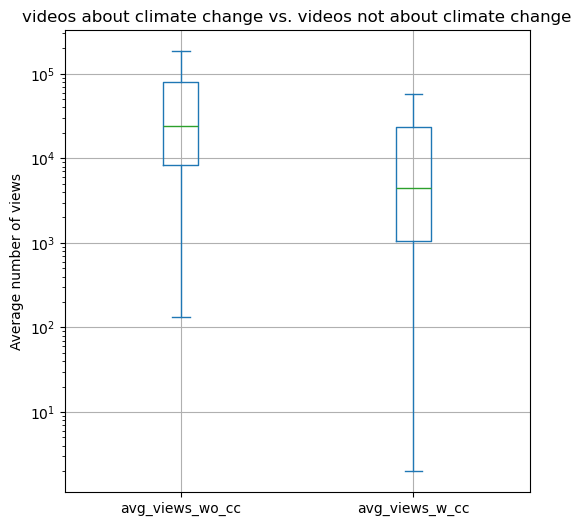

In [480]:
fig, ax = plt.subplots(figsize = (6, 6))

#color = {
#    "boxes": "DarkGreen",
#    "whiskers": "DarkOrange",
#    "medians": "DarkBlue",
#    "caps": "Gray",
#}

ch_views_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='box', grid=True, ax=ax, showfliers=False) #, color=color
ax.set_yscale("log")

plt.title('videos about climate change vs. videos not about climate change')
#plt.legend(['videos not about climate change', 'videos about climate change'], loc='upper right')
plt.ylabel('Average number of views')
#plt.xlabel('Channel name')
plt.show()

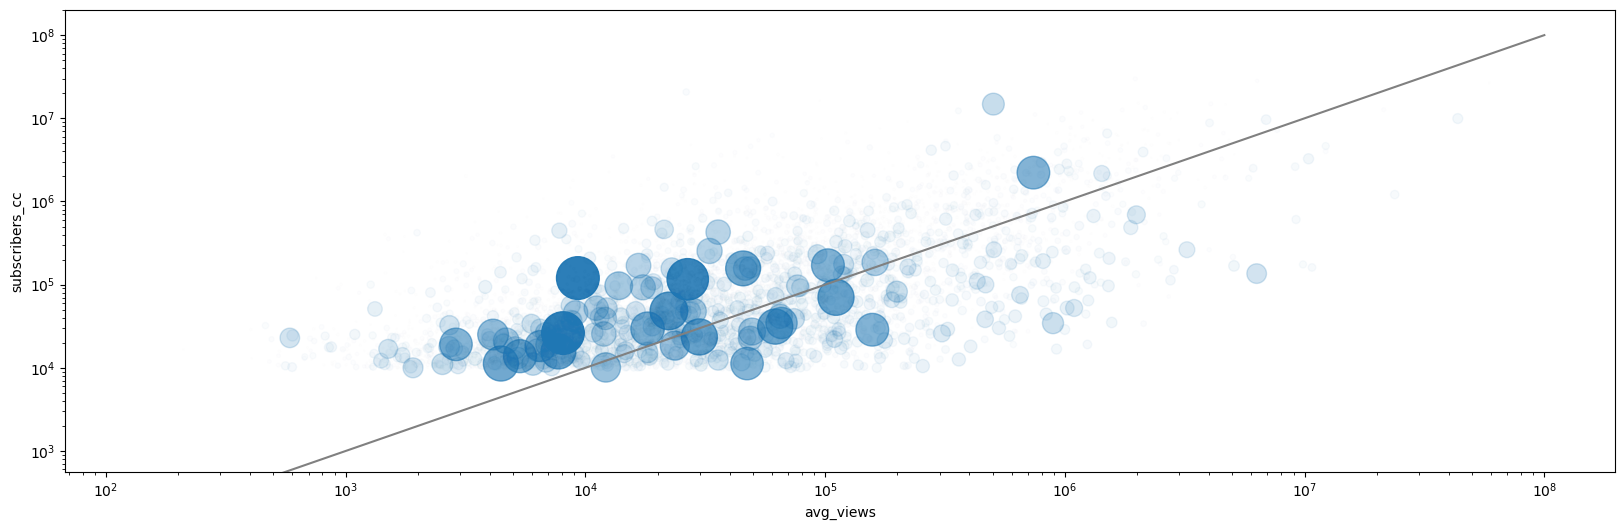

In [313]:
fig, ax = plt.subplots(figsize = (20, 6))

ch_views_df.plot.scatter(x='avg_views', y='subscribers_cc', s=ch_views_df['proportion_climate_videos']*1000, ax=ax, alpha=ch_views_df['proportion_climate_videos'])
#ch_views_df.plot.scatter(x='avg_views', y='subscribers_cc', s=(1-ch_views_df['proportion_climate_videos'])*3000, ax=ax, color='red', alpha=0.5)

x = range(0, 10**8, 1000)
plt.plot(x, x, color='darkgray')

ax.set_xscale("log")
ax.set_yscale("log")

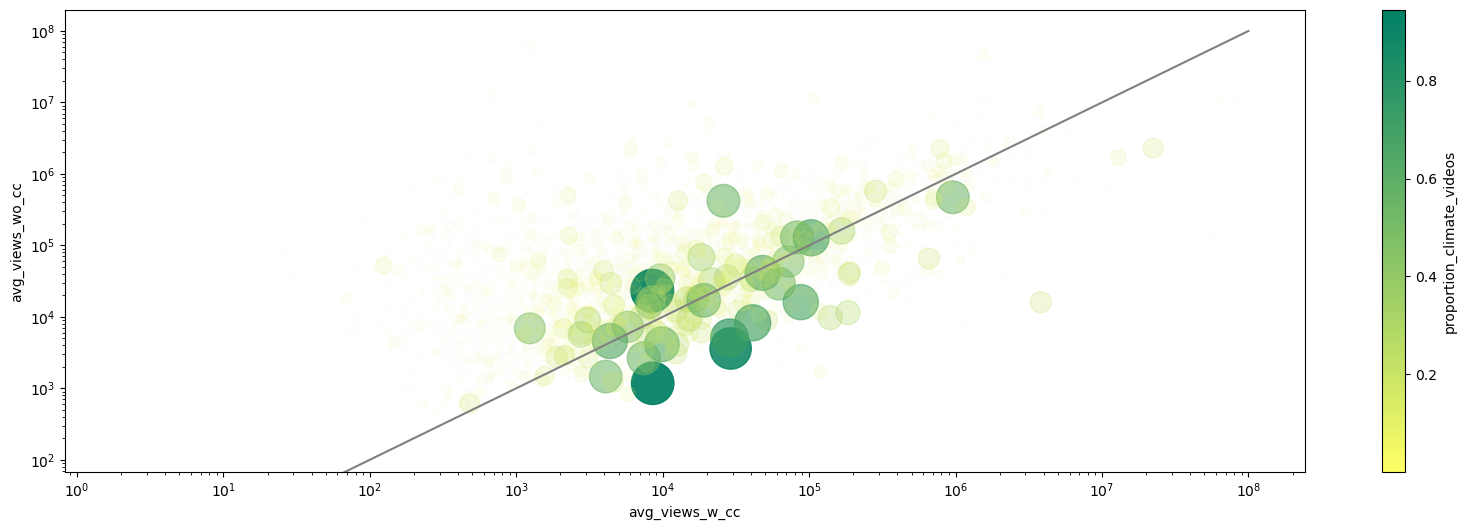

In [463]:
fig, ax = plt.subplots(figsize = (20, 6))

ch_views_df.plot.scatter(x='avg_views_w_cc', y='avg_views_wo_cc', s=ch_views_df['proportion_climate_videos']*1000, ax=ax, alpha=ch_views_df['proportion_climate_videos'], c='proportion_climate_videos', colormap='summer_r')
#ch_views_df.plot.scatter(x='avg_views', y='subscribers_cc', s=(1-ch_views_df['proportion_climate_videos'])*3000, ax=ax, color='red', alpha=0.5)

x = range(0, 10**8, 1000)
plt.plot(x, x, color='darkgray')

ax.set_xscale("log")
ax.set_yscale("log")

La j'ai l'imp que les channels avec un gros ratio de cc vid elles sont quand meme plus importantes dans le game

le graph suivant c'est le même sauf que la taille ne depend plus du ratio mais de la quantité de videos faites

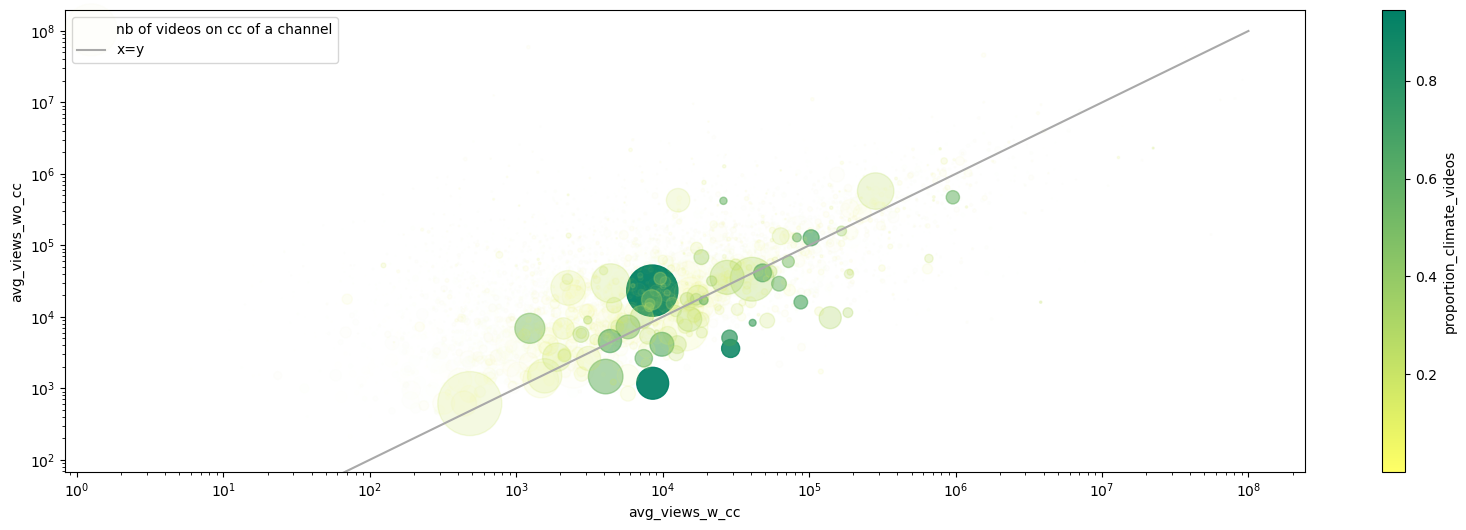

In [478]:
fig, ax = plt.subplots(figsize = (20, 6))

#tt = ch_views_df['tt_cc_videos'].sum()

#ch_views_df.plot.scatter(x='avg_views_w_cc', y='avg_views_wo_cc', s=ch_views_df['tt_cc_videos'], ax=ax, alpha=ch_views_df['proportion_climate_videos']) #alpha=ch_views_df['tt_cc_videos']*30/tt
ch_views_df.plot.scatter(x='avg_views_w_cc', y='avg_views_wo_cc', s=ch_views_df['tt_cc_videos']*0.9, ax=ax, c='proportion_climate_videos', colormap='summer_r', alpha=ch_views_df['proportion_climate_videos'])

x = range(0, 10**8, 1000)
plt.plot(x, x, color='darkgray')

ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(['nb of videos on cc of a channel', 'x=y'], loc='upper left')

# plus les ronds sont gros plus y'a de videos cc
# plus les ronds sont fonces plus la chaine a un haut ratio de videos cc

On considerait toutes les chaines qui avaient des videos sur le climate change et on comparait leur moyenne de vues
pour leurs videos avec et sans le topic du cc.  
Maintenant on considere les channels qui ont un ration sup à 25% donc qui sont des channels dont le sujet du cc
c'est imp et du coup ptet leurs subscribers les suit en partie pour cette raison.  
Du coup on va voir si être dans le theme du cc et faire des videos dessus c'est benef.

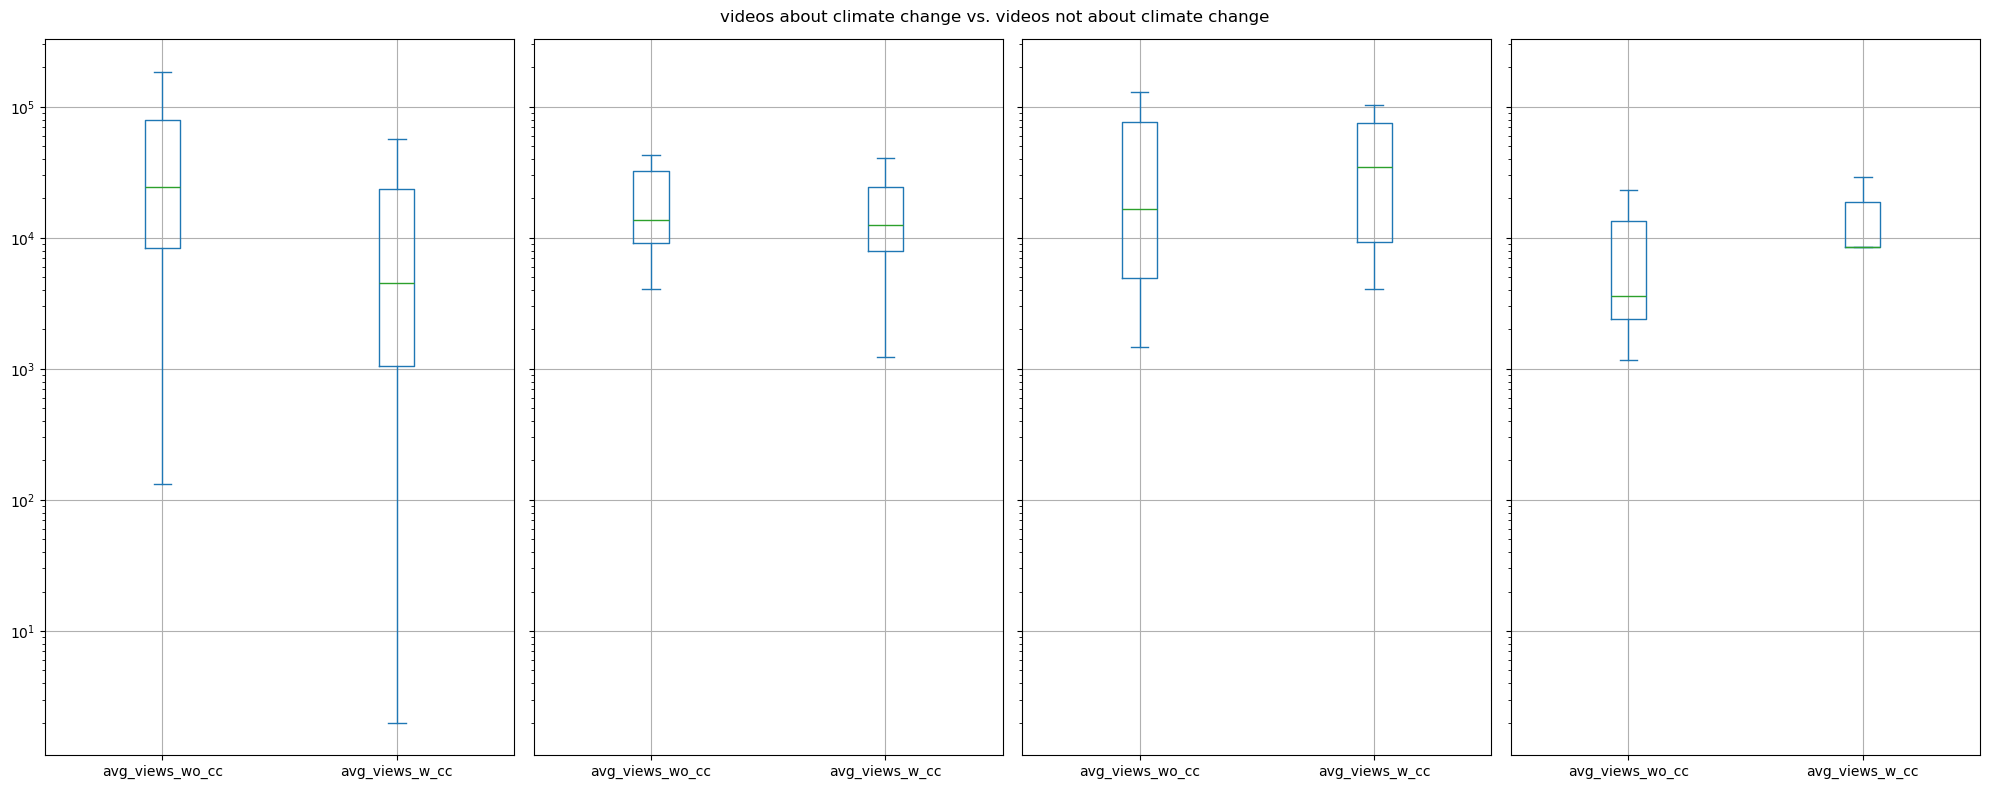

In [479]:
ch_views_cc25_df = ch_views_df[ch_views_df['proportion_climate_videos'] <= 0.25].dropna()
ch_views_cc50_df = ch_views_df[(ch_views_df['proportion_climate_videos'] > 0.25) & (ch_views_df['proportion_climate_videos'] <= 0.5)].dropna()
ch_views_cc75_df = ch_views_df[(ch_views_df['proportion_climate_videos'] > 0.5) & (ch_views_df['proportion_climate_videos'] <= 0.75)].dropna()
ch_views_cc100_df = ch_views_df[ch_views_df['proportion_climate_videos'] > 0.75].dropna()

fig, (pA, pB, pC, pD) = plt.subplots(1, 4, figsize=(20, 8), sharey=True)

ch_views_cc25_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='box', grid=True, ax=pA, showfliers=False)
ch_views_cc50_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='box', grid=True, ax=pB, showfliers=False)
ch_views_cc75_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='box', grid=True, ax=pC, showfliers=False)
ch_views_cc100_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='box', grid=True, ax=pD, showfliers=False)
pA.set_yscale("log")

fig.suptitle('videos about climate change vs. videos not about climate change')
fig.tight_layout()
#plt.legend(['videos not about climate change', 'videos about climate change'], loc='upper right')
plt.ylabel('Average number of views')
#plt.xlabel('Channel name')
plt.show()

Ptet faire la meme sauf considérer au dessus de 50 et pas faire la derniere pcq je crois y'a pas beaucoup de chaines qui ont un tel ratio donc pas tres parlant  

Aussi on voit que dans le premier plot il y a quand meme pas mal de videos qui ont percées de manière hors norme mais c'est aussi le cas pour les vids wo cc  
  
Du coup la datastory serait: si t'es pas dans le monde du cc faire une video dessus ne t'apportera pas plus de vues  
Par contre si ta chaine elle est stylée et qu'elle parle du cc faire des vids dessus vu que ton puplic ça l'intéresse ça fait + de vues

## Est-ce qu'une video doit etre avant ou apres un event pour qu'elle perce ?

I think 52 events is a bit much  
Or maybe do the same but with the 10 most important events  
le pb c'est qu'on considere quoi comme evenement important ? pcq on peut pas prendre celui qui a eu le + de vues ça biaiserait de fou l'analyse faudrait demander une plus petite liste à chatGPT

In [414]:
climate_events = pd.read_csv('data/climate_events.csv')
climate_events['date'] = pd.to_datetime(climate_events['date'])

# y'avais des events qui se repettaient donc je les ai enlevés

In [453]:
climate_events['before_event'] = climate_events['date'] - pd.Timedelta(days=7)
climate_events['after_event'] = climate_events['date'] + pd.Timedelta(days=7)

#climate_events.set_index('date', inplace=True)
#climate_events.sort_index(inplace=True)
#climate_events = climate_events.loc['2010': '2019-09-28']

display(climate_events.head(2))
print(climate_events.shape)

,date,name_of_event,before_event,after_event,nb_videos_before,nb_videos_after,avg_views_before,avg_views_after
0,2010-01-12,Haiti Earthquake and Its Impact on Vulnerable ...,2010-01-06,2010-01-18,39.0,53.0,8000.230769,33718.528302
1,2010-02-27,Madeira Floods: Flash Flooding and Urban Vulne...,2010-02-21,2010-03-05,49.0,37.0,80112.387755,98554.972973
2,2010-04-20,Deepwater Horizon Oil Spill,2010-04-14,2010-04-26,52.0,68.0,14067.923077,41297.529412
3,2010-07-06,Russia Wildfires and the Role of Forest Manage...,2010-06-30,2010-07-12,25.0,46.0,64102.520000,23148.608696
4,2010-07-07,Mumbai Floods: Urban Flooding and Climate Adap...,2010-07-01,2010-07-13,29.0,43.0,24472.000000,18635.534884


(52, 8)


In [454]:
file_path = "data/refine_filtered_videos.jsonl"
videos_df = pd.read_json(file_path, lines=True)
videos_df.dropna(inplace=True, subset='view_count')
videos_df.sort_values(by='view_count', inplace=True, ascending=False)

In [455]:
videos_df['upload_date'] = pd.to_datetime(videos_df['upload_date']) #, format='mixed'
videos_df.set_index('upload_date', inplace=True)
videos_df.sort_index(inplace=True)
videos_df = videos_df.loc['2010': '2019-09-28']
display(videos_df.head(2))

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,view_count
upload_date,,,,,,,,,,,
2010-01-01,Science & Technology,UCAuUUnT6oDeKwE6v1NGQxug,2019-10-30 06:49:52.555071,http://www.ted.com For the dawn of a new decad...,39.0,lxYFURQ7Ehw,1219,461.0,"Bertrand,Piccard,TEDTalks,TED,talks,adventure,...",Bertrand Piccard's solar-powered adventure,47140.0
2010-01-01,Nonprofits & Activism,UCgKadKkzK-Ea_YnogNKtOlA,2019-10-30 01:25:43.684437,Humanity thrives when it seeks information and...,22.0,OFzoeLbdcXE,173,217.0,"Climate,Change,Copenhagen,Peak,Oil,Water,Food,...",Why Do We Stop Thinking?,27619.0
2010-01-02,Music,UC4PLXk_mz1-P_Et6k79iMPQ,2019-11-16 18:01:46.322962,Watch this entertaining video to understand ho...,49.0,WRNd6K8kS4M,596,477.0,"cap,and,trade,carbon,footprint,offset,pollutio...",Cap And Trade - Carbon Offset - Carbon Footpri...,71625.0
2010-01-02,Entertainment,UCjNxszyFPasDdRoD9J6X-sw,2019-10-31 19:12:40.111517,Barack Obama came to us and said he offered Ch...,304.0,bMdmxKUeqPQ,155,3949.0,"2009,Sarah,Palin,Michael,Jackson,Global,Warmin...","Goodbye, 2009",98083.0
2010-01-02,News & Politics,UCpwvZwUam-URkxB7g4USKpg,2019-10-31 12:50:13.590780,"Decades pass, the socio-economic climate chang...",9.0,2ljgNMU_VoI,149,42.0,"New,Year,Red,Square,Moscow,holidays,January,Ru...",Red Square best place to celebrate New Year,5530.0


In [456]:
#climate_events['nb_views'] = videos_df.between_time(pd.to_datetime(climate_events['before_event']), pd.to_datetime(climate_events['after_event'])).value_counts()
#climate_events['nb_views'] = videos_df.loc[pd.to_datetime(climate_events['before_event']): pd.to_datetime(climate_events['after_event'])]
#climate_events['nb_views'] = videos_df.loc[climate_events.index-pd.Timedelta(days=7):climate_events.index+pd.Timedelta(days=7)].fillna(0).value_counts()

new_df = videos_df['view_count']

for index, row in tqdm(climate_events.iterrows()):
    climate_events.loc[index, 'nb_videos_before'] = new_df.loc[row['before_event']: row['date']-pd.Timedelta(days=1)].shape[0]
    climate_events.loc[index, 'nb_videos_after'] = new_df.loc[row['date']: row['after_event']].shape[0]
    climate_events.loc[index, 'avg_views_before'] = (new_df.loc[row['before_event']: row['date']-pd.Timedelta(days=1)].sum())/climate_events.loc[index, 'nb_videos_before']
    climate_events.loc[index, 'avg_views_after'] = (new_df.loc[row['date']: row['after_event']].sum())/climate_events.loc[index, 'nb_videos_after']

display(climate_events.head(2))

22it [00:00, 217.82it/s]

52it [00:00, 157.27it/s]


,date,name_of_event,before_event,after_event,nb_videos_before,nb_videos_after,avg_views_before,avg_views_after
0,2010-01-12,Haiti Earthquake and Its Impact on Vulnerable ...,2010-01-06,2010-01-18,32.0,46.0,6872.843750,38626.130435
1,2010-02-27,Madeira Floods: Flash Flooding and Urban Vulne...,2010-02-21,2010-03-05,46.0,35.0,36387.260870,103600.514286
2,2010-04-20,Deepwater Horizon Oil Spill,2010-04-14,2010-04-26,37.0,60.0,8588.513514,39493.916667
3,2010-07-06,Russia Wildfires and the Role of Forest Manage...,2010-06-30,2010-07-12,16.0,40.0,25454.937500,20803.500000
4,2010-07-07,Mumbai Floods: Urban Flooding and Climate Adap...,2010-07-01,2010-07-13,24.0,33.0,27691.458333,23103.848485


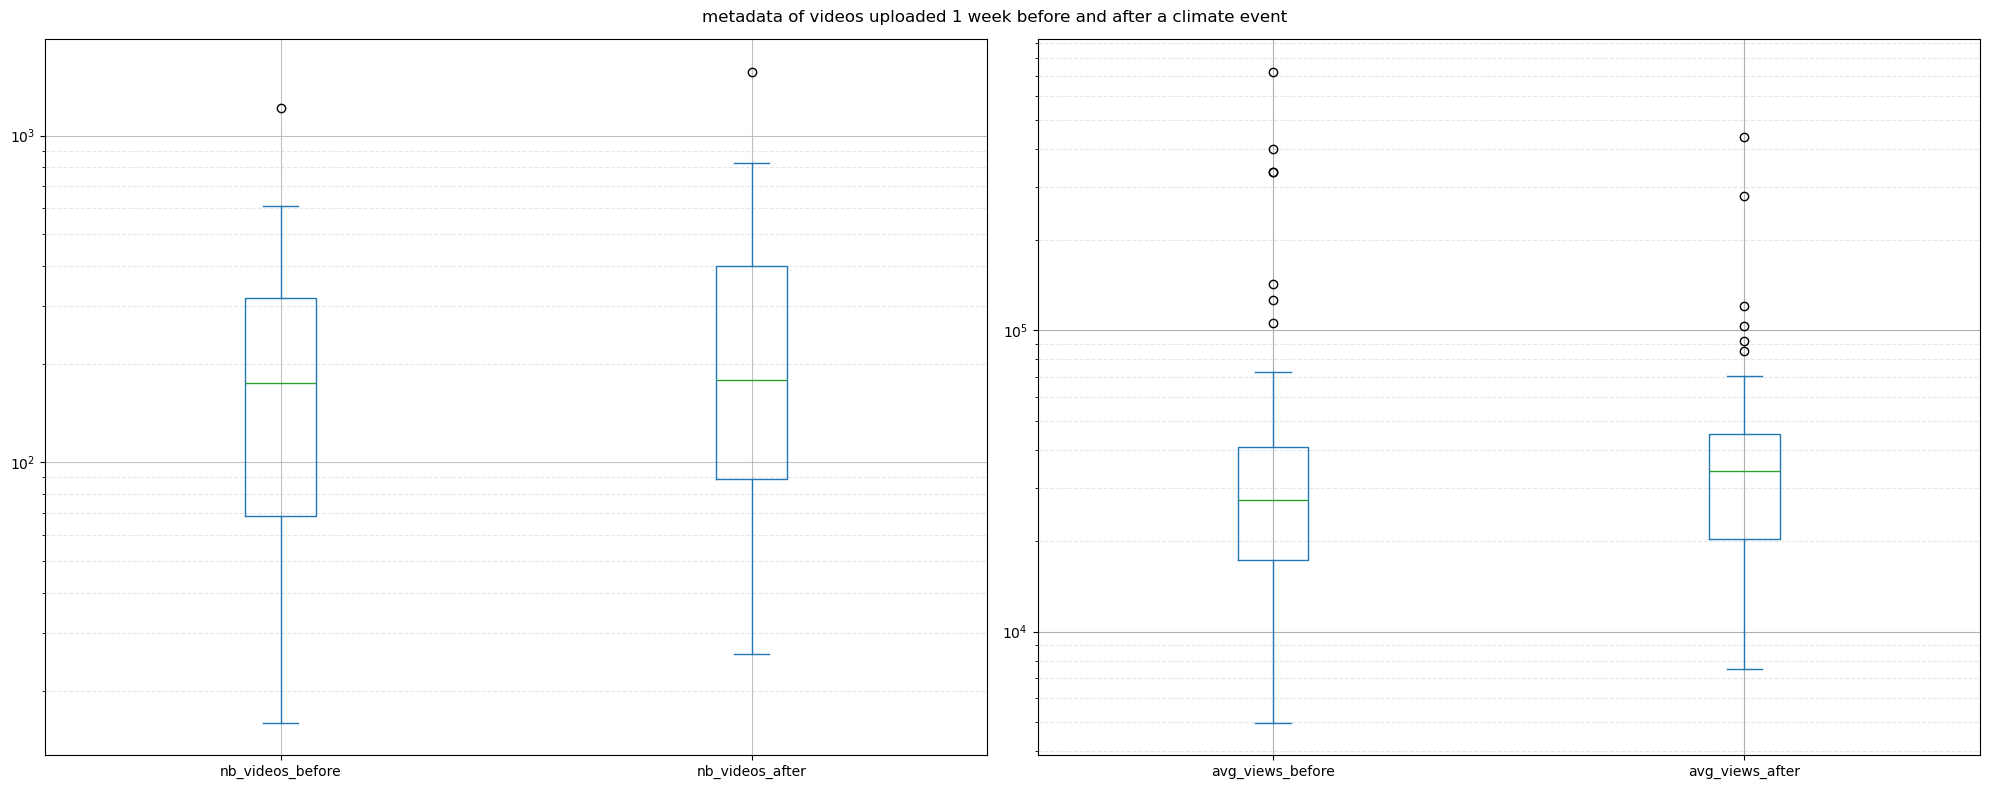

In [477]:
fig, (pA, pB) = plt.subplots(1, 2, figsize=(20, 8))

climate_events[['nb_videos_before', 'nb_videos_after']].plot(kind='box', grid=True, ax=pA) #, color=color
climate_events[['avg_views_before', 'avg_views_after']].plot(kind='box', grid=True, ax=pB)
pA.set_yscale("log")
pA.grid(which='minor', alpha=0.3, linestyle='--')
pA.grid(which='major', alpha=0.8)
pB.set_yscale("log")
pB.grid(which='minor', alpha=0.3, linestyle='--')
pA.grid(which='major', alpha=0.8)

fig.suptitle('metadata of videos uploaded 1 week before and after a climate event')
fig.tight_layout()
#plt.legend(['videos not about climate change', 'videos about climate change'], loc='upper right')
#plt.ylabel('Average number of views')
#plt.xlabel('Channel name')
plt.show()

In [ ]:
#b
timeseries_cc_df = timeseries_df.merge(tt_views_cc_df, how='inner', on='channel')
#display(timeseries_cc_df.sort_values(by="datetime"))
display(ch_views_df.head(2))

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
8698774,UC1Ru5ZqoiF1cFwQSuFuv-KA,Gaming,2015-01-05 00:00:00,3111235.0,0.0,16818.0,0.0,0,0,0
2462377,UCnYwVM9uyLGzTFfAkWqiUdQ,Gaming,2015-01-05 00:00:00,25800145.0,0.0,70829.0,0.0,1420,0,20


                                  channel         views  videos  cc_views  \
name                                                                        
1000frolly PhD   UCAR0Oi4L0Om4F26uwpANgCg  1.034144e+07     167   9356772   
Climate Reality  UCIJk74xZtFZut1rJVHVVXeA  4.029099e+06     522   3174000   

                 cc_videos  avg_views_wo_cc  avg_views_w_cc     avg_views  \
name                                                                        
1000frolly PhD         106     16142.053864    88271.433962  61924.774166   
Climate Reality        320      4233.162659     9918.750000   7718.580186   

                  subs  proportion_cc_vids  
name                                        
1000frolly PhD   31300            0.634731  
Climate Reality  15655            0.613027  


MemoryError: Unable to allocate 1.27 GiB for an array with shape (9, 18872499) and data type float64

In [ ]:
timeseries_cc_df['datetime'] = pd.to_datetime(timeseries_cc_df['datetime'])
#timeseries_cc_df.set_index('datetime', inplace=True)

datetime
2015-10-04    2.763444e+06
2017-01-15    1.657210e+06
2019-03-03    1.252437e+06
2019-08-11    1.237905e+06
2019-06-02    1.236083e+06
2015-10-11    1.235470e+06
2019-02-24    1.223705e+06
2019-09-29    1.216466e+06
2019-07-28    1.215694e+06
2019-09-22    1.204173e+06
Name: delta_views, dtype: float64

<Axes: xlabel='datetime'>

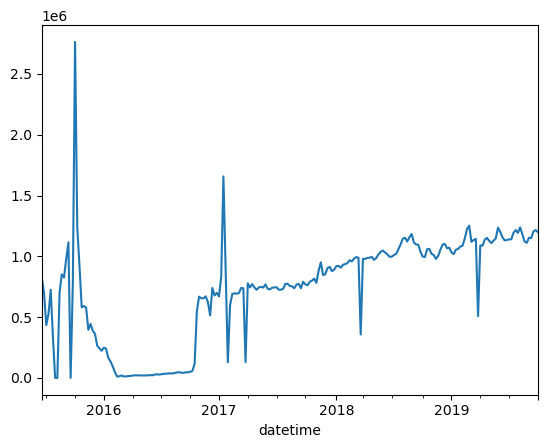

In [ ]:
avg_week_view_df = timeseries_cc_df.groupby(pd.Grouper(key='datetime', freq='W'))['delta_views'].mean().dropna()

display(avg_week_view_df.sort_values(ascending=False).head(10))
avg_week_view_df.plot()

<Axes: xlabel='datetime'>

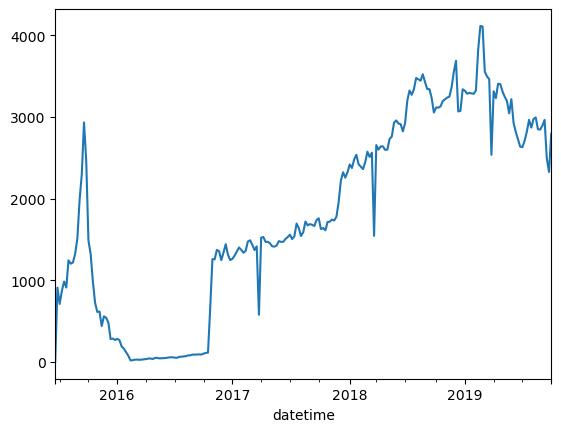

In [ ]:
avg_gain_sub_df = timeseries_cc_df.groupby(pd.Grouper(key='datetime', freq='W'))['delta_subs'].mean().dropna()
avg_gain_sub_df.plot()

In [ ]:
climate_events['before_event'] = pd.to_datetime(climate_events['before_event'])
climate_events['after_event'] = pd.to_datetime(climate_events['after_event'])

trump_paris_agr = climate_events[climate_events['date'] == '2016-11-08']
#2017-06-01,Trump Announces Withdrawal from Paris Agreement
#2016-11-08
display(trump_paris_agr)

KeyError: 'before_event'

In [ ]:
#avg_week_view_filt_df.plot()

avg_week_view_filt_df = avg_week_view_df[
    (avg_week_view_df.index > (trump_paris_agr['date'].iloc[0]  - pd.Timedelta(days=20))) &
    (avg_week_view_df.index <= (trump_paris_agr['date'].iloc[0] + pd.Timedelta(days=20)))
]

display(avg_week_view_filt_df)

# Plot the graph
#plt.plot(avg_week_view_filt_df['Date'], avg_week_view_filt_df['Value'], marker='o', linestyle='-', color='b')
avg_week_view_filt_df.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data within Event Date Range')
plt.show()

NameError: name 'trump_paris_agr' is not defined

In [ ]:
#videos_df['upload_date'] = pd.to_datetime(videos_df['upload_date'])
trump_paris_agr_vids_df = videos_df.loc['2015-09-27'].sort_values(by='view_count', ascending=False)
# interesting channels: UC1yBKRuGpC1tSM73A0ZjYjQ UCaXkIU1QidjPwiAYu6GcHjg # UCZaT_X_mc0BI-djXOlfhqWQ
display(trump_paris_agr_vids_df.head()) #['description'].iloc[0]

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,view_count,classification_categories
upload_date,,,,,,,,,,,,
2015-09-27,Howto & Style,UCI_6GbMUIZ8bti4GQbqQpow,2019-11-02 16:11:49.988235,Smallest solar powered car. Clean energy tran...,6.0,nNCD0gCl7b4,124,67.0,"Solar Car,Solar Energy (Industry)",Minifigure riding clean energy car,23726,{'/Business & Industrial/Energy & Utilities/Re...
2015-09-27,News & Politics,UC5O114-PQNYkurlTg6hekZw,2019-11-12 16:42:36.395062,"United Nations - ""Protecting our Planet and Co...",20.0,iK_qzk6sJS4,120,186.0,"UN,United Nations (Membership Organization),Cl...",Protecting our planet and combating climate ch...,17025,{'/People & Society/Social Issues & Advocacy/G...
2015-09-27,News & Politics,UCZfsrIV68Oegr5bJgAMLBDA,2019-11-14 01:06:36.222959,The UN's Sustainable Development Goals lays ou...,5.0,C0eNCiuAI5I,98,44.0,"UN,global goals,sustainable development,17 goa...","UN Global Goals: Life Below Water, Reduced Ine...",10202,{'/People & Society/Social Issues & Advocacy/G...
2015-09-27,News & Politics,UC5O114-PQNYkurlTg6hekZw,2019-11-12 16:42:37.317541,"United Nations - ""Building Effective, Accounta...",13.0,NCf4xAfPzTc,101,35.0,"UN,United Nations (Membership Organization),Su...",Building effective accountable and inclusive ...,6777,{'/Law & Government/Government/Other': 0.72254...
2015-09-27,News & Politics,UC6ZhpmNnLxlOYipqh8wbM3A,2019-11-02 07:12:41.629174,The President Speaks at the 2030 Agenda for Su...,13.0,9tJNxGvgOaE,1684,30.0,"Barack Obama (US President),Development,Presid...",President Obama at 2030 Agenda for Sustainable...,4819,{'/Law & Government/Government/Executive Branc...


In [ ]:
imp_events = pd.read_csv('DATA/climate_events_v2.csv')
display(imp_events.head(2))
imp_events['Date'] = pd.to_datetime(imp_events['Date'])
imp_events.set_index('Date', inplace=True)

climate_events.set_index('Date', inplace=True)

,Date,Event Name,Short Description
0,2010-04-20,Deepwater Horizon Oil Spill,A devastating oil spill in the Gulf of Mexico...
1,2010-08-01,Russian Heat Wave,Unprecedented heatwave in Russia leading to w...


C:\Users\nasta\AppData\Local\Temp\ipykernel_21420\1368379172.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch['datetime'] = pd.to_datetime(ch['datetime'])
C:\Users\nasta\AppData\Local\Temp\ipykernel_21420\1368379172.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch['datetime'] = pd.to_datetime(ch['datetime'])
C:\Users\nasta\AppData\Local\Temp\ipykernel_21420\1368379172.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

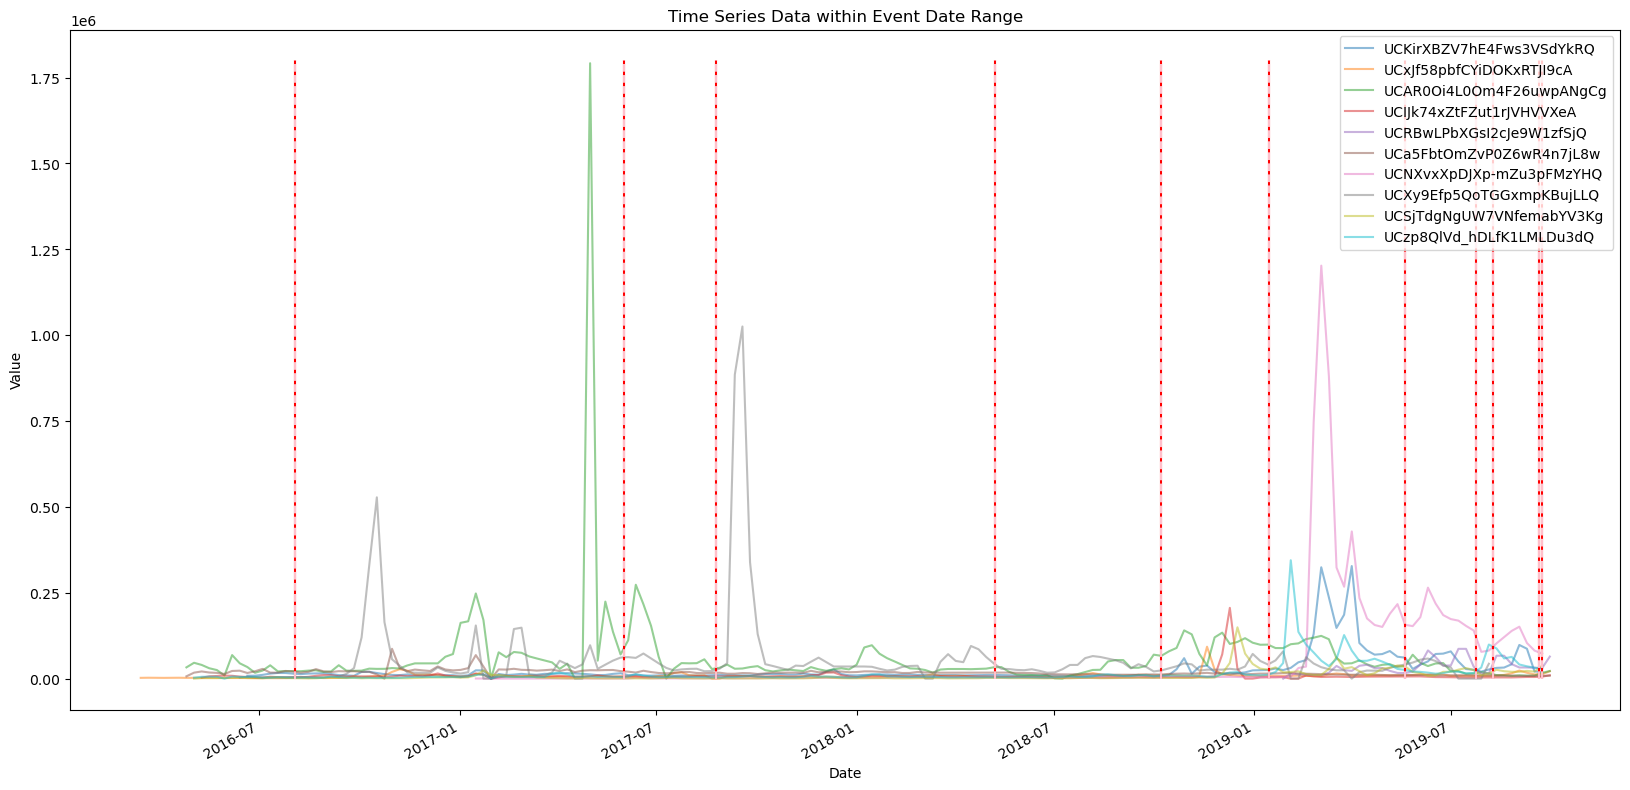

In [ ]:
ch_list = [timeseries_cc_df[timeseries_cc_df['channel'] == 'UCKirXBZV7hE4Fws3VSdYkRQ'], 
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCxJf58pbfCYiDOKxRTJI9cA'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCAR0Oi4L0Om4F26uwpANgCg'], 
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCIJk74xZtFZut1rJVHVVXeA'], 
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCRBwLPbXGsI2cJe9W1zfSjQ'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCa5FbtOmZvP0Z6wR4n7jL8w'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCNXvxXpDJXp-mZu3pFMzYHQ'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCXy9Efp5QoTGGxmpKBujLLQ'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCSjTdgNgUW7VNfemabYV3Kg'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCzp8QlVd_hDLfK1LMLDu3dQ']
]

fig = plt.figure(figsize=(20, 10))

for ch in ch_list:
    ch['datetime'] = pd.to_datetime(ch['datetime'])
    ch.set_index('datetime', inplace=True)
    ch['delta_views'].plot(label=ch['channel'].iloc[0], legend=True, alpha=0.5)

plt.vlines(climate_events.loc['2016':'2019-10'].index, 0, ymax=1800000, colors='pink', linestyles='--', label="Important events")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data within Event Date Range')
plt.show()

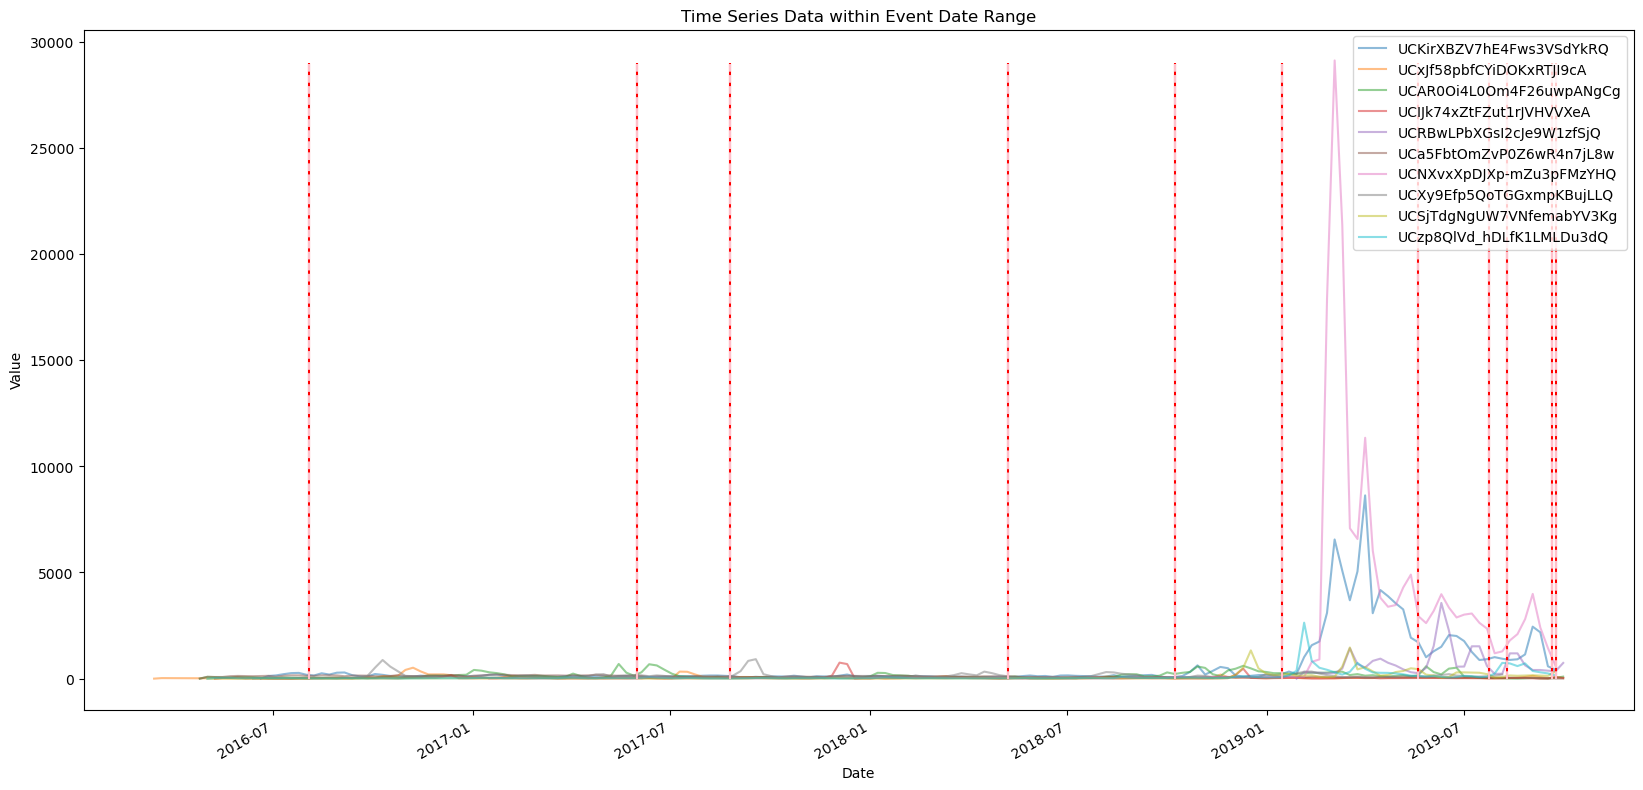

In [ ]:
fig = plt.figure(figsize=(20, 10))

for ch in ch_list:
    #ch['datetime'] = pd.to_datetime(ch['datetime'])
    #ch.set_index('datetime', inplace=True)
    ch['delta_subs'].plot(label=ch['channel'].iloc[0], legend=True, alpha=0.5)

plt.vlines(imp_events.loc['2016':'2019-10'].index, 0, ymax=29000, colors='r', label="Important events")
plt.vlines(climate_events.loc['2016':'2019-10'].index, 0, ymax=29000, colors='pink', linestyles='--', label="Important events")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data within Event Date Range')
plt.show()

In [ ]:
display(videos_df.loc[videos_df['channel_id'] == 'UCXy9Efp5QoTGGxmpKBujLLQ'].loc[:'2017'].sort_values(by='view_count', ascending=False).head(10))

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,view_count,classification_categories
upload_date,,,,,,,,,,,,
2017-05-23,Science & Technology,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:04.095345,The East Siberian Arctic Shelf has received mo...,30.0,eJfOWfaP6RI,688,467.0,"Natalia Shakhova,University of Alaska Fairbank...",Methane in the East Siberian Arctic Shelf (2017),56621,{'/Science/Ecology & Environment/Climate Chang...
2017-11-23,Science & Technology,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:00.365574,Rapid collapse of Antarctic glaciers could flo...,72.0,Pp5kK0Td-Vc,707,557.0,"Eric Holthaus,Pine Island Glacier,Thwaits Glac...",Ice Apocalypse - MULTIPLE METERS SEA LEVEL RISE,54646,{'/Science/Ecology & Environment/Climate Chang...
2017-06-10,News & Politics,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:01.892955,One idea likely to be both controversial and e...,39.0,FadyWlTdi2Y,878,199.0,"SLR,Sea level rise,Miami,Shorecrest,South Flor...",Florida plans to abandon Property to the Sea (...,18513,{'/People & Society/Social Issues & Advocacy/G...
2017-06-07,Science & Technology,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:02.472732,"For the first time, underwater pingos have bee...",8.0,9XmRzMwITjA,325,176.0,"Pingo,gas hydrate pingo,CAGE,Center for Arctic...",Large Underwater Methane seeping Structures ca...,11326,{'/Science/Earth Sciences/Geology': 0.50532829...
2017-06-04,Science & Technology,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:02.989961,Like ‘champagne bottles being opened’: Scienti...,3.0,9q3c9CErdmA,611,119.0,"Stephen Grasby,CAGE,Methane,methane hydrate,cl...","Like Champagne Bottles Pop, Methane Explosions...",5045,{'/Science/Earth Sciences/Other': 0.5575139523...
2017-06-13,Education,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:00.855331,"Yoda, Luke and C3PO explain surprising climate...",8.0,2eaMz0lMg10,257,41.0,"wet-bulb temperature,weather,superstorms,snows...",5 Surprising Climate Change Effects,1236,{'/Science/Ecology & Environment/Climate Chang...
